<h1 style="color:#333333; text-align:center; line-height: 0;"> <img style="right;" src="logo.png" width=18% height=18%> Advanced Control | Assignment 2 
</h1>
<br/><br/>

**First, familiarize yourself with [Rcognita](https://github.com/AIDynamicAction/rcognita) if you have not already done so. This assignment is based on this framework, so it's better to have an intuition about what's going on behind the scenes.**

The goal of this assignment is to implement a classic **MPC** controller, described in the section 1.2, namely, `_actor_cost` and `_actor_optimizer` methods.

___Total points:___ 100

<h2 style="color:#A7BD3F;"> Section 1: Introduction to model predictive control (MPC) </h2>

***
###  <font color="blue"> 1.1 Intuition behind MPC </font>
**MPC** is one of the most popular methods of obtaining the optimal controller and, in fact, is an industry standard.
Let us start from the most reasonable question. Why should we care about **MPC**? Why do we even need that thing? Are there any problems that naturally lead to the development of such a model?

In fact, yes. There are infinitely many applications of **MPC**, including petroleum extraction, agricultural facilities, automatic assembly and so on. But let us take a look at the development of such a type of machines that are impressive not only to an expert in the field - humanoid robots. If you've ever seen a video of Boston Dynamics' humanoid robots, you've probably wondered, how do the engineers made it work? How does such a complex machine make those precise movements so that it is capable of performing acrobatics that already exceeds the abilities of a typical human in some aspects (i.e. backflip)?

The answer is, you guessed it, **MPC**. 

The performance of the modern robots comes with its cost. The problem of generating control for any robot requires:

- real time performance, as there are in general almost no stable states in the robot's movement, and all the calculations should be performed quickly
- optimizing a complex composite cost to a certain time horizon in order to follow the high-level plan
- (in some cases) discrete-continuous optimization, which is difficult
- taking into account various types of constraints, i.e.
    1. torque and angle limits for the servomotors (in a form of inequality)
    2. functional constraints following from the problem statement, that do not always allow for an analytical solution 
    3. also there could be constraints on foot placement, body placement, slippery surfaces, etc.
    4. constraints of the limbs non-intersection (if this is a case)

All in all, such a problem could lack a closed form solution, like $\boldsymbol u = \boldsymbol f(\text{state}, \text{target})$.

One of the most fundamental important ways to obtain an optimal controller is __MPC__. 

* __MPC-like algorithms__ are ones of the few that can handle very complex constraints, including functional, nonlinear, nonconvex, etc.

Informally speaking, algorithms that generate control for a complex dynamical system typically have to be predictive. And taking the system model into account helps along the way. In order to optimize an objective along the trajectory, we could try to estimate the system behaviour in the future. This is litearlly what **MPC** does. With that in hand, let us state the problem and the **MPC** more formally.

###  <font color="blue"> 1.2 MPC mathematical description </font>
<a id='2.2'></a>

First of all, we consider a controlled physical system described by the system of ordinary differential equations 
<a id='System'></a>
\begin{equation}
\begin{cases}
\dot{\boldsymbol x} = \boldsymbol f(\boldsymbol x, \boldsymbol u)\\
\boldsymbol y = h(\boldsymbol x) \\
\boldsymbol x(0)=\boldsymbol x_{0}\\
\end{cases}
\end{equation} where $x_{0}$ is the **initial state**.In the following table we introduce some basic notation. From now on, we will write vectors in **bold**.
<a id='Notation'></a>

| Notation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| Description |
|:-----------------------:|-------------|
| $\boldsymbol f(\cdot, \cdot) : \mathbb{R}^{n} \times \mathbb{R}^{m} \rightarrow \mathbb{R}^{n}$ |A **state dynamic function** or, more informally, **righ-hand-side** of a system <br /> of ordinary differential equations $\dot{\boldsymbol x} = \boldsymbol f(\boldsymbol x, \boldsymbol u)$|
| $\boldsymbol x \in \mathbb{R}^{n} $ | An element of the **state space** of a controlled system of dimensionality $n$ |
| $\boldsymbol u \in \mathbb{R}^{m}$ | An element of the **action space** of a controlled system of dimensionality $m$ |
| $\boldsymbol y \in \mathbb{R}^{k}$ | An **observartion**|
| $\mathbb{X}\subset \mathbb{R}^{n} $| **State constraint set**|
| $\mathbb{U}\subset \mathbb{R}^{m} $| **Action constraint set**|
| $\boldsymbol h(\cdot): \mathbb{R}^{n} \rightarrow \mathbb{R}^{k}$ | **Observation function**  |
| $\kappa(\cdot) : \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ | **Policy** function |
| $\rho(\cdot) : \mathbb{R}^n \rightarrow \mathbb{R}$ | **Stage cost** function  |
| $J_N(\cdot, \cdot): \mathbb{R}^n \times \mathcal{K} \rightarrow \mathbb{R}$| **N-step cost** (might be refered as **actor cost** either), <br /> where $\mathcal{K}$ is some functional space of admissible policies |
| $\delta$ | **Sampling time** |
| $\boldsymbol x_k$   | A **state** at time $k\delta$: $\qquad\boldsymbol x (k \delta)$   |

Here we would like to make a few clarifications on the notation introduced.
* For **MPC** N-step cost has the following form  $J_N(\boldsymbol x_{k}, \kappa(\cdot)):=\int_{k\delta}^{(k+N)\delta}\rho(\boldsymbol x(t), \kappa(\boldsymbol x(t))) dt$
* In the following problems we consider $\mathbb{X} = \mathbb{R}^{n}$ without any remarks but in general we might want to introduce some reasonable **state constraint set**.
* When working with the system, we cannot know the exact value of the characteristics we are interested in. What we do is **make a measurement** calculatung **observation function** $\boldsymbol h(\cdot)$. The result we call an **observation** $\boldsymbol y$. For now we consider $\boldsymbol y = \boldsymbol h(\boldsymbol x) := \boldsymbol x$ further but in general it might not be so! For example, if we control a body motion on a plane $(x,y)$, we could measure a distance to the origin: $\boldsymbol h(\boldsymbol x) = \lVert \boldsymbol x \rVert$. 
* Most modern controllers are digital, therefore the control signal is generated by sampling with some **sampling time** $\delta$. In that case we call it **digital control setting**. The following table gives a comparison between mathematical description of the original setting of the controlled system and its **digital control setting**.
<a id='Comparison_table'></a>
|  Original setting | Digital control setting |
|:-----------------------|:--------------------------|
|1) $ \qquad \dot{\boldsymbol x}=\boldsymbol f\left(\boldsymbol x, \boldsymbol u\right) $ | $\text{1*)} \quad \dot{\boldsymbol x}=\boldsymbol f\left(\boldsymbol x, \boldsymbol u^{\delta}\right)$|
| $\text{2)} \quad \boldsymbol u=\boldsymbol u(t), t \in[0, T]$  | $\text{2*)} \quad \boldsymbol u_k(t)=\boldsymbol u(k\delta) , t \in[k \delta,(k+1) \delta]$  | 
| $$\text{3)} \quad \boldsymbol x(t):=\boldsymbol x_{t_0}+\int_{t_0}^{t}f\left(\boldsymbol x(\tau), \boldsymbol u(\tau) \right) d \tau$$| $$\text{3*)} \quad \boldsymbol x^{\boldsymbol u_{k}}(t):=\boldsymbol x_{k}+\int_{k \delta}^{t}f\left(\boldsymbol x(\tau), \boldsymbol u_{k}\right) d \tau$$|     

<!--- $$\boldsymbol x_{i \mid k}:=\boldsymbol x((k+i-1) \delta), k \in \mathbb{N}$$
$\boldsymbol u^{\delta}(t) \equiv \boldsymbol u_{i \mid k}=\kappa\left(\boldsymbol x_{i \mid k}\right), t \in[k \delta,(k+i) \delta]$ 
One can see that for any $k \in \mathbb{N}$, the state $x^{u_{k}}(t)$ at $t \geq k \delta$ under $u_{k}$ satisfies
-->
<p style="text-align: center;">

</p>

From now and on by the system we mean a system in the **digital control setting**, which is illustrated on the figure below .
<img src="digital_control_setting.svg" width=40% height=40% />

**Objective:**

In general, our optimal control problem is written as $\min_{\kappa(\cdot)}\int_{k\delta}^{(k+N)\delta}\rho(\boldsymbol x(t), \kappa(\boldsymbol x(t))) dt$, where $N$ is **prediction horizon**. But in **MPC** we switch to a discrete sum instead of an integral: $$\min _{\boldsymbol u_{k + i}: i=0, \ldots, N-1} \left(\sum_{i=1}^{N-1} \rho \left(\hat{\boldsymbol x}_{k + i}, \boldsymbol u_{k + i}\right)\delta \right) $$ Wich is obviously equivalent to the following form:
$$\min _{ \boldsymbol u_{k + i}: i=0, \ldots, N-1} \left(\sum_{i=1}^{N-1} \rho \left(\hat{\boldsymbol x}_{k + i}, \boldsymbol u_{k + i}\right)\right)$$  
And now we see that it fits conviniently in our **digital control setting**: we will just find a minimizing sequence of actions for our digital model predictive control for stage costs predicted for N steps forward.  Notice that under digital control our state evolves according to [3*)](#Comparison_table) . Now we need to somehow numerically evaluate the interal $\int_{k \delta}^{t}f\left(\boldsymbol x(\tau), \boldsymbol u_{k}\right) d \tau$. In order to do this one might use any numerical integration scheme. For example the **Euler scheme** :
<a id='Euler'></a>
$$
\boldsymbol x_{k+1}=\boldsymbol x_{k}+\delta \boldsymbol f\left(\boldsymbol x_{k}, \boldsymbol u_{k}\right) \text {, }
$$
#### Algorithm <sup>[1]</sup>:
<a id='Objective'></a>
Let us describe the **MPC** algorithm for the problem just described above.  
At the current state $\boldsymbol x_{k}$ :

(a) **MPC** solves an $N$-step lookahead  problem: $\min _{\boldsymbol u_{k + i}: i=0, \ldots, N-1} \left(\sum_{i=0}^{N-1} \rho \left(\hat{\boldsymbol x}_{k + i}, \boldsymbol u_{k + i}\right)\right)$

(b) If $\left\{\boldsymbol u^{*}_{k}, \ldots, \boldsymbol u^{*}_{k+N-1}\right\}$ is the optimal control sequence of this problem, **MPC** applies $\boldsymbol u^{*}_{k}$ and discards the other controls $\boldsymbol u^{*}_{k+1}, \ldots, \boldsymbol u^{*}_{k+N-1}$. 

(c) At the next stage, **MPC** repeats this process, once the next state $\boldsymbol x_{k}$ is revealed.


<img src="MPC.svg" width=35% height=35% />

***

<h2 style="color:#A7BD3F;"> Section 2: Problems </h2>

In the following, for testing, we will use a system representing a three-wheeled robot described by a system of equations
$$\begin{cases}
\dot{x}_c=v \cos \alpha \\
\dot{y}_c=v \sin \alpha \\
\dot{\alpha}=\omega
\end{cases}$$ where $x_c$ and $y_c$ are coordinates of the center of mass, $v$ and $\omega$ are velocity of the center of mass and angular velocity respectively and these are components of the control $\boldsymbol u := (v, \omega)$ as well.  

***

### <font color="blue"> 2.1 Preparation of environment </font>
So, let's get started! The cell below contains some imports from Rcognita submodule that was cloned into your current directory in case you did everything correctly. Execute the following code and check out you don't have any errors.

In [1]:
"""
DO NOT MODIFY
"""
import warnings
with warnings.catch_warnings(record=True):
    import extras
    import matplotlib.animation as animation
    import matplotlib.pyplot as plt
    import numpy as np
    from rcognita.rcognita import simulator
    from rcognita.rcognita import systems
    from rcognita.rcognita import controllers
    from rcognita.rcognita import loggers
    from rcognita.rcognita import visuals
    from rcognita.rcognita.utilities import on_key_press
    from rcognita.rcognita.utilities import dss_sim
    from rcognita.rcognita.utilities import rep_mat
    from rcognita.rcognita.utilities import uptria2vec
    from rcognita.rcognita.utilities import push_vec
    from scipy.optimize import minimize
    import scipy as sp

%matplotlib notebook
%load_ext autoreload
%autoreload 2

#### Configuration and arguments
The code below is using `extras.py`file contains default arguments using for preset.

In [2]:
"""
The parser below is defined in the respective argparser_*.py file
You can familiarize yourself with default arguments using this file. 
Change the code only if you really know what you are doing.
"""
args = extras.parser.parse_args(['--ctrl_mode','MPC'])

if not isinstance(args.state_init[0], int):
    for k in range(len(args.state_init)):
        args.state_init[k] = eval( args.state_init[k].replace('pi', str(np.pi)) )

args.state_init = np.array(args.state_init)
args.action_manual = np.array(args.action_manual)
dim_state = 3
args.dim_state = dim_state
args.state_init = np.array(args.state_init)
args.action_manual = np.array(args.action_manual)
args.dim_state = 3
args.dim_input = 2
args.dim_output = args.dim_state
args.dim_disturb = 0
args.grade1 = 0
args.grade2 = 1

args.dim_R1 = args.dim_output + args.dim_input
args.dim_R2 = args.dim_R1
args.pred_step_size = args.dt * args.pred_step_size_multiplier

args.R1 = np.diag(np.array(args.R1_diag))
args.R2 = np.diag(np.array(args.R2_diag))
assert args.t1 > args.dt > 0.0
assert args.state_init.size == dim_state
globals().update(vars(args))
is_disturb = 0
is_dyn_ctrl = 0

t0 = 0

action_init = 0 * np.ones(dim_input)

# Solver
atol = 1e-5
rtol = 1e-3

# xy-plane
xMin = -10
xMax = 10
yMin = -10
yMax = 10

# Control constraints
v_min = -25
v_max = 25
omega_min = -5
omega_max = 5
ctrl_bnds=np.array([[v_min, v_max], [omega_min, omega_max]])

### <font color="blue"> 2.2 Problem 1 | Actor cost computation </font>

***

In this section we will implement the `_actor_cost` method that basically does two things:
1. Given a sequence of $N$ actions, it **computes the resulting sequence of N predicted observations**.
2. Given the previously obtained sequence of $N$ observations it **computes and returns $N$-step cost** 

**Input data**:
* `action_sqn` - **action** sequence
$
\left(\begin{array}{c} 
v^1 \\ 
\omega^1 \\
\vdots \\
v^N \\ 
\omega^N \\
\end{array}\right)
$
where $v^i$ and $\omega^i$ are velocity of the center of mass and angular velocity respectively. **Dimension**:`[dim_input*N,]`

* `observation` - An initial **observation** vector 
$
\left(\begin{array}{c} 
x_c(k\delta) \\ 
y_c(k\delta) \\
\alpha(k\delta)\\
\end{array}\right)
$
 for some $k$, from which calculation of prediction starts. **Dimension**:`[dim_output,]` (recall `dim_output`$=3$)

**Output data**:
* `J` - $N$-step cost. A `float` value.

***

Here are a few essential tips for this problem:
* `self.state_sys -> numpy.ndarray` - An **observation** $\boldsymbol y$ of the [system](#System) from which prediction starts (Keep in mind that $\boldsymbol h(\boldsymbol x):=\boldsymbol x$). **Dimension**: `[dim_output,]`
*  **Action** has a **dimension**  `[dim_input,]`
* `self.sys_rhs(t, state, action) -> np.ndarray` returns a value of the [**state dynamic function**](#System) .  (_Our dynamical system doesn't depend on time explicitly. So, pass an empty list instead, for example:_ `self.sys_rhs([], var, var)`).
* `self.Nactor -> int` is the **prediction horizon** (number of steps denoted by $N$ in the algorithm description in the section [1.2](#2.2))
* `self.pred_step_size -> float` is the **step size** $\delta$
* `self.stage_obj(observation, action) -> float` is the **stage objective** $\rho \left(\boldsymbol x_{k+i}, \boldsymbol u_{k+i}\right)$
* You can choose any suitable numerical integration method to compute corresponding integral $ \boldsymbol x^{u_{k}}(t):=\boldsymbol x_{k}+\int_{k \delta}^{t} \boldsymbol f\left(\boldsymbol x(\tau), \boldsymbol u_{k}\right) d \tau $ to obtain state prediction for further total cost calculation. For example, [Euler scheme](#Euler)

***

**Due to grading purposes, please create a  variable `observation_sqn` and store all states in it. It should be an `np.ndarray` and have a dimension of `[N, dim_output]`**

In [3]:
class CtrlOptPredWithoutOptimizer(controllers.CtrlOptPred):
    def _actor_cost(self, action_sqn, observation):
        #############################################
        # YOUR CODE BELOW
        #############################################
        observation_sqn = np.zeros((self.Nactor,self.dim_output))
        xk = observation
        observation_sqn[0,:] = xk
        uk = action_sqn[0:2]
        s = 0
        s +=self.stage_obj(xk, uk)
        for i in range(1,self.Nactor):
            xk = xk + self.pred_step_size * self.sys_rhs([],xk,uk)
            uk = action_sqn[2*i:2*i+2]
            s +=self.stage_obj(xk, uk)
            observation_sqn[i,:] = xk
        J = s
        #############################################
        # YOUR CODE ABOVE
        #############################################
        self.observation_sqn = observation_sqn
        
        return J # J -- N-step cost

In [4]:
a = np.zeros((5,2))
a[0,:]

array([0., 0.])

### <font color="blue"> 2.3 Problem 1 | Testing of the N-step cost method implementation </font>

***

Executing of the following cell invokes a test procedure for **N-step cost** computation. There is reference data that was generated for grading of the assignment. So, all grades are based on unit-tests with the following parameters:

* **Prediction horizon** $N = 30$
* 3 action sequences of lenght 30


It creates a report with the following structure: 
* $l_1$-difference metric
* $l_2$-difference metric
* $l_\infty$-difference metric
* Plots of reference and test predictions


<IPython.core.display.Javascript object>


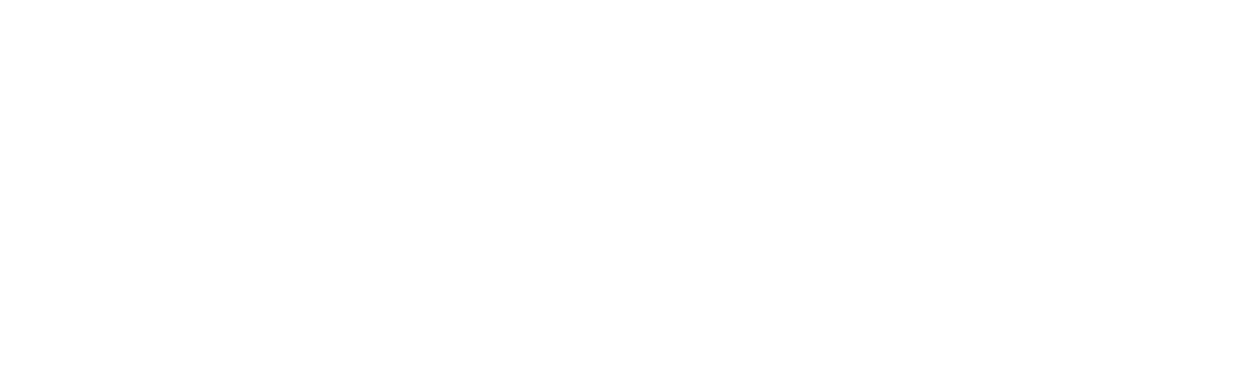

,$\quad$ Sinusoidal $\quad$,$\quad$ Linear $\quad$,$\quad$ Constant $\quad$
$l_1$-difference metric,0.0,0.0,0.0
$l_2$-difference metric,0.0,0.0,0.0
$l_\infty$-difference metric,0.0,0.0,0.0


max difference between reference and predicted observations equals 0.0 and small enough. Success!


In [5]:
my_sys = systems.Sys3WRobotNI(sys_type="diff_eqn",
                                     dim_state=dim_state,
                                     dim_input=dim_input,
                                     dim_output=dim_output,
                                     dim_disturb=dim_disturb,
                                     pars=[],
                                     ctrl_bnds=10*np.array([[-1,-1],[1,1]]),
                                     is_dyn_ctrl=0,
                                     is_disturb=0,
                                     pars_disturb=[])



test_controller = CtrlOptPredWithoutOptimizer(dim_input=dim_input,
                                dim_output=dim_output,
                                ctrl_bnds = 10*np.array([[-1,-1],[1,1]]),
                                action_init = [],
                                t0 = 0,
                                sampling_time = 0.01,
                                Nactor = 30,
                                pred_step_size = 0.01,
                                sys_rhs = my_sys._state_dyn,
                                sys_out = my_sys.out,
                                state_sys = state_init,
                                gamma = 1,
                                stage_obj_struct = stage_obj_struct,
                                stage_obj_pars = [R1],
                                observation_target = [])

ref_observations = extras.generate_data_for_task(test_controller)
grade1 = extras.test_first_task_procedure(test_controller, ref_observations)

### <font color="blue"> 2.4 Problem 2 | Implementation of actor optimizer method. </font>

In this section we implement the `_actor_optimizer()` method that performs the constrained minimization of the $N$-step cost: $$\min _{\boldsymbol u_{k+i}: i=0, \ldots, N-1} \left(\sum_{i=0}^{N-1} \rho \left(\hat{\boldsymbol  x}_{k+i}, \boldsymbol u_{k+i}\right)\right)\\
 \quad \boldsymbol u_{k+i} \in U
$$

Where $U$ is the ation constraints set.

**Input data**:

* `observation` - An initial **observation** vector $\boldsymbol y_k =$
$
\left(\begin{array}{c} 
x_c(k\delta) \\ 
y_c(k\delta) \\
\alpha(k\delta)\\
\end{array}\right)
$
 for some $k$, from which calculation of prediction starts. **Dimension**:`[dim_output,]` (recall `dim_output`$=3$)

**Output data**:
* `action_sqn` - **action** sequence $[\boldsymbol u_1, \dots , \boldsymbol u_N] =$
$
\left(\begin{array}{c} 
v^1 \\ 
\omega^1 \\
\vdots \\
v^N \\ 
\omega^N \\
\end{array}\right)
$
where $v^i$ and $\omega^i$ are velocity of the center of mass and angular velocity respectively. **Dimension**:`[dim_input*N,]`

Here are a few tips for this problem as well:
* To compute the $N$-step cost use previously implemented method `_actor_cost()`
* Using `sp.optimize.Bounds` implement constraints set $U$ for our optimization problem. Exact minimum and maximum values of action you can obtain using `self.action_sqn_min` and `self.action_sqn_max`
* Choose suitable hyperparameters for optimization. For example, `tolerance`, `max_iter`, `method` and so on. 
* To solve this problem you may use SciPy otimizer. Examine [docs](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) of the corresponding minimizator and apply it to `_actor_cost()`
* `self.dim_input` is the dimensionality of action
* Don't forget you need to return only the **first action**.

In [6]:
class CtrlOptPredStudent(CtrlOptPredWithoutOptimizer):
    def _actor_optimizer(self, observation):
        #############################################
        # YOUR CODE BELOW
        #############################################
        
        J = lambda actions: self._actor_cost(actions, observation)
        bnds = sp.optimize.Bounds(self.action_sqn_min,self.action_sqn_max)
        #U0 = (self.action_sqn_max - self.action_sqn_min)/2
        
        U0 = self.action_sqn_min + np.random.rand(self.dim_input*self.Nactor)*(self.action_sqn_max - self.action_sqn_min)
        res = sp.optimize.minimize(J, U0, method='TNC', bounds=bnds)
        action_sqn = res.x
        
        #############################################
        # YOUR CODE ABOVE
        #############################################
        return action_sqn[:self.dim_input]

In [7]:
minn=np.array([-5,-10]*3)
maxx =np.array([5,10]*3)
minn + np.random.rand(2*3)*(maxx - minn)

array([-3.52559885, -4.41841335, -1.54065832,  4.34438619, -2.78642562,
       -7.40311856])

### <font color="blue"> 2.5 Problem 2 | Testing of the implemented controller </font>

Launch all the following code after the controller is implemented. You will see the final results of your work in the end of the notebook. 

#### System initialization

In the following cell we will instantiate a 3-wheel robot system for controller testing. 

In [8]:
my_sys = systems.Sys3WRobotNI(sys_type="diff_eqn",
                                     dim_state=dim_state,
                                     dim_input=dim_input,
                                     dim_output=dim_output,
                                     dim_disturb=dim_disturb,
                                     pars=[],
                                     ctrl_bnds=ctrl_bnds,
                                     is_dyn_ctrl=is_dyn_ctrl,
                                     is_disturb=is_disturb,
                                     pars_disturb=[])

observation_init = my_sys.out(state_init)

xCoord0 = state_init[0]
yCoord0 = state_init[1]

alpha0 = state_init[2]
alpha_deg_0 = alpha0/2/np.pi

#### Implemented controller initialization

In the following code we create an instance of the class of the controller you implemented earlier. It will be used in the final test in the end of the notebook.

In [9]:
my_ctrl_opt_pred = CtrlOptPredStudent(dim_input=dim_input,
                                dim_output=dim_output,
                                ctrl_bnds = ctrl_bnds,
                                action_init = [],
                                t0 = t0,
                                sampling_time = dt,
                                Nactor = Nactor,
                                pred_step_size = pred_step_size,
                                sys_rhs = my_sys._state_dyn,
                                sys_out = my_sys.out,
                                state_sys = state_init,
                                gamma = gamma,
                                stage_obj_struct = stage_obj_struct,
                                stage_obj_pars = [R1],
                                observation_target = [])

#### Simulator initialization

Simulator is a module of Rcognita framework which performs simulation of closed loops. Below we create an instance of the `Simulator` class and to use it further

In [10]:
my_simulator = simulator.Simulator(sys_type = "diff_eqn",
                                   closed_loop_rhs = my_sys.closed_loop_rhs,
                                   sys_out = my_sys.out,
                                   state_init = state_init,
                                   disturb_init = [],
                                   action_init = action_init,
                                   t0 = t0,
                                   t1 = t1,
                                   dt = dt,
                                   max_step = dt/2,
                                   first_step = 1e-6,
                                   atol = atol,
                                   rtol = rtol,
                                   is_disturb = is_disturb,
                                   is_dyn_ctrl = is_dyn_ctrl)

####  Main loop

This is a main part of testing procedure. 

<IPython.core.display.Javascript object>


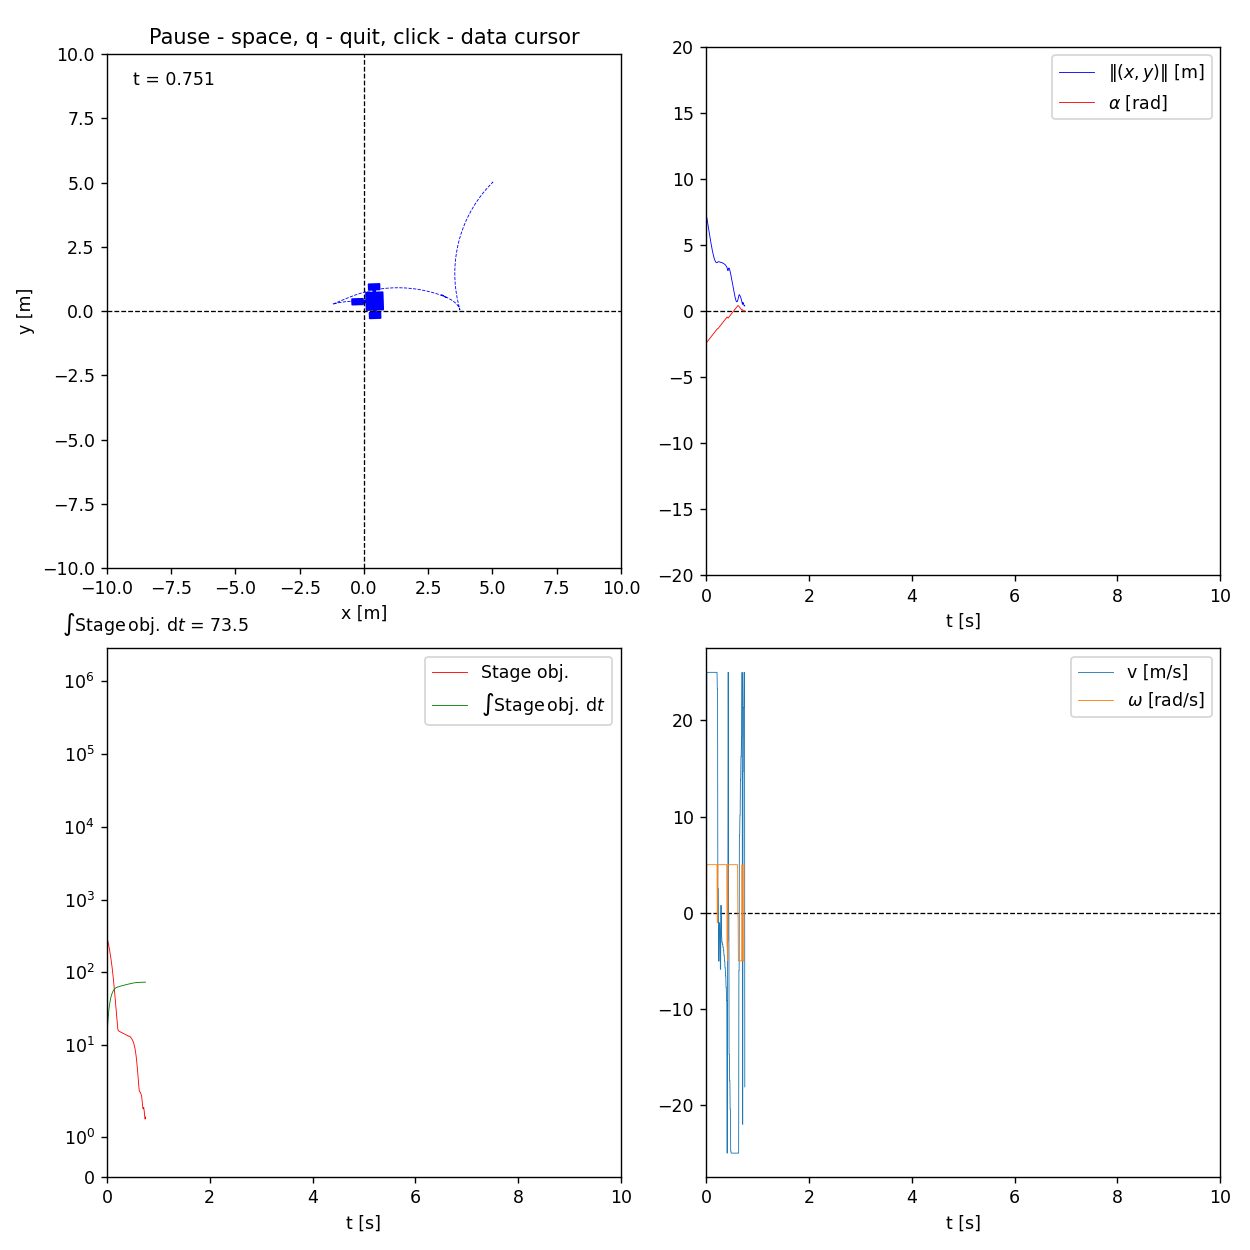

In [11]:
##### Just to make things work
state_full_init = my_simulator.state_full
my_logger = loggers.Logger3WRobotNI()
full_trajectory = []
datafiles = [None] * Nruns
my_logger = loggers.Logger3WRobotNI()
my_ctrl_nominal = controllers.CtrlNominal3WRobotNI(ctrl_gain=0.5, ctrl_bnds=ctrl_bnds, 
                                                                  t0=t0, 
                                                                  sampling_time=dt)
my_ctrl_benchm = my_ctrl_opt_pred

# Debug
is_visualization = True
step_number = 0
verbosity_level = 200

if is_visualization:
    my_animator = extras.Animator3WRobotNI_traj(objects=(my_simulator,
                                                     my_sys,
                                                     controllers.CtrlNominal3WRobotNI(ctrl_gain=0.5, 
                                                                                      ctrl_bnds=ctrl_bnds, 
                                                                                      t0=t0, 
                                                                                      sampling_time=dt),
                                                     my_ctrl_opt_pred,
                                                     [None] * Nruns,
                                                     controllers.ctrl_selector,
                                                     my_logger),
                                            pars=(state_init,
                                                  action_init,
                                                  t0,
                                                  t1,
                                                  state_full_init,
                                                  xMin,
                                                  xMax,
                                                  yMin,
                                                  yMax,
                                                  'MPC',
                                                  action_manual,
                                                  v_min,
                                                  omega_min,
                                                  v_max,
                                                  omega_max,
                                                  Nruns,
                                                    is_print_sim_step, is_log_data, 0, []))

    anm = animation.FuncAnimation(my_animator.fig_sim,
                                  my_animator.animate,
                                  init_func=my_animator.init_anim,
                                  blit=False, interval=dt/1e6, repeat=False)

    my_animator.get_anm(anm)

    cId = my_animator.fig_sim.canvas.mpl_connect('key_press_event', lambda event: on_key_press(event, anm))

    anm.running = True

    my_animator.fig_sim.tight_layout()
    plt.show()
    
else:   
    run_curr = 1
    datafile = datafiles[0]
    
    while True:
        
        my_simulator.sim_step()
        
        t, state, observation, state_full = my_simulator.get_sim_step_data()
        
        action = controllers.ctrl_selector(t, observation, action_manual, my_ctrl_nominal, my_ctrl_benchm, ctrl_mode)
        
        my_sys.receive_action(action)
        my_ctrl_benchm.receive_sys_state(my_sys._state)
        my_ctrl_benchm.upd_accum_obj(observation, action)
        
        xCoord = state_full[0]
        yCoord = state_full[1]
        alpha = state_full[2]
        
        stage_obj = my_ctrl_benchm.stage_obj(observation, action)
        accum_obj = my_ctrl_benchm.accum_obj_val
        
        if is_print_sim_step & (step_number % verbosity_level == 0):
            my_logger.print_sim_step(t, xCoord, yCoord, alpha, stage_obj, accum_obj, action)
            
        if is_log_data:
            my_logger.log_data_row(datafile, t, xCoord, yCoord, alpha, stage_obj, accum_obj, action)
        step_number += 1
        if t >= t1:  
            if is_print_sim_step:
                print('.....................................Run {run:2d} done.....................................'.format(run = run_curr))
                
            run_curr += 1
            
            if run_curr > Nruns:
                break
                
            if is_log_data:
                datafile = datafiles[run_curr-1]
            
            # Reset simulator
            my_simulator.status = 'running'
            my_simulator.t = t0
            my_simulator.observation = state_full_init
            
            if ctrl_mode != 'nominal':
                my_ctrl_benchm.reset(t0)
            else:
                my_ctrl_nominal.reset(t0)
            
            accum_obj = 0

+----------+----------+----------+---------------+-------------+-------------+-----------+-----------------+
|    t [s] |    x [m] |    y [m] |   alpha [rad] |   stage_obj |   accum_obj |   v [m/s] |   omega [rad/s] |
+==========+==========+==========+===============+=============+=============+===========+=================+
|    0.066 |    4.193 |    3.942 |        -2.089 |       177.3 |        41.6 |    25.000 |           5.000 |
+----------+----------+----------+---------------+-------------+-------------+-----------+-----------------+


<IPython.core.display.Javascript object>


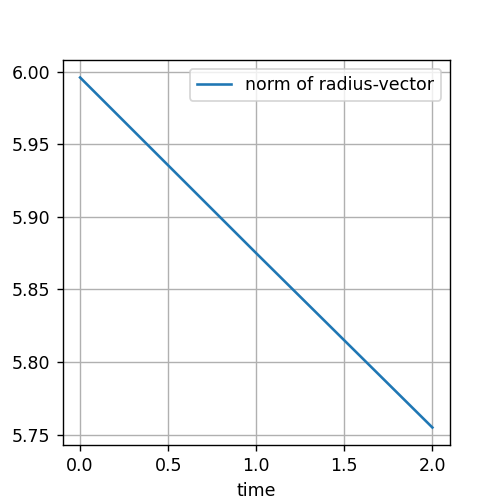

0.3373052350045797


In [13]:
grade2 = extras.integral_grading(my_animator.full_trajectory)

### Grading

Run this cell to see the resulting grade.

In [14]:
### GRADING DO NOT MODIFY
extras.final_grade(grade1, grade2)


+----------+----------+----------+---------------+-------------+-------------+-----------+-----------------+
|    t [s] |    x [m] |    y [m] |   alpha [rad] |   stage_obj |   accum_obj |   v [m/s] |   omega [rad/s] |
+==========+==========+==========+===============+=============+=============+===========+=================+
|    0.171 |    3.536 |    1.432 |        -1.564 |        35.4 |        61.2 |    25.000 |           5.000 |
+----------+----------+----------+---------------+-------------+-------------+-----------+-----------------+


<strong> Your grade is: 87</strong>

<text style=color:brown> Acceptable :) </text>

True

## Questions?

Reach out to **Ilya Osokin (@elijahmipt)** or **Georgiy Malaniya (@odinmaniac)** on Telegram.

## Sources

 ***
 **<sup>[1]</sup> Bertsekas, D. , Reinforcement Learning and Optimal Control**

